# Text Sentiment Analysis on IMDB dataset

In this notebook, we will be working with the IMDB Moview Review dataset, which contains a text review alongwith its corresponding label - positive (1) or negative (0). The dataset has contains 50000 reviews, which is divided into train and test sets of 25000 reviews each. 
Original dataset can be found at following link:
https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

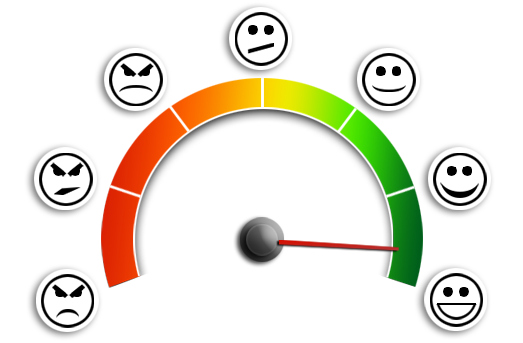

We will perform following activities:
* Build a classifier to perform Sentiment Analysis on the given data 
* Explore the performance of various Neural Network based models (DNN, LSTM, GRU, Ensemble model)
* Visualize the relationship between Word Embeddings using Tensorboard

In [2]:
# Import libraries

import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)

2.3.0


### Load Dataset

Tensorflow provides an easy way to download the data using Tensorflow datasets. 

In [3]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Separate text sentences and labels from both train and test sets.

In [4]:
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [5]:
print(f"length of training sentences: {len(training_sentences)}")
print(f"length of training labels: {len(training_labels_final)}")
print(f"length of testing sentences: {len(testing_sentences)}")
print(f"length of testing labels: {len(testing_labels_final)}")

length of training sentences: 25000
length of training labels: 25000
length of testing sentences: 25000
length of testing labels: 25000


In [6]:
print(np.unique(training_labels_final, return_counts=True))
print(np.unique(testing_labels_final, return_counts=True))

(array([0, 1]), array([12500, 12500]))
(array([0, 1]), array([12500, 12500]))


Both training and test data are equally divided into positive(1) and negative(0) labels

In [7]:
vocab_size = 10000     # max length of vocabulary (no. of unique words)
embedding_dim = 16     # dimension of embedding layer
max_length = 120       # maximum length of all sequences
trunc_type='post'      # position from where to truncate larger sentences 
oov_tok = "<OOV>"      # token to replace 'Out of vocabulary' words


# Create Tokenizer object which will be used to convert sentences into numeric sequence vectors 
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Use training data to train/fit the Tokenizer with
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index


In [8]:
# Define function to convert sentences into numeric sequence vectors (trained on vocabulary of training data) 
def transform_string(sentences):
    return pad_sequences(tokenizer.texts_to_sequences(sentences),maxlen=max_length, truncating=trunc_type)

In [9]:
training_sequence = transform_string(training_sentences)
testing_sequence = transform_string(testing_sentences)

Lets visualize how a sentence looks after it gets transformed using *word_index* (adjusted length, padded, matched with vocabulary)

In [10]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print('Original sentence:')
print(training_sentences[15])
print('\nTransformed sentence:')
print(decode_review(training_sequence[15]))

Original sentence:
It was disgusting and painful. What a waste of a cast! I swear, the audience (1/2 full) laughed TWICE in 90 minutes. This is not a lie. Do not even rent it.<br /><br />Zeta Jones was just too mean to be believable.<br /><br />Cusack was OK. Just OK. I felt sorry for him (the actor) in case people remember this mess.<br /><br />Roberts was the same as she always is. Charming and sweet, but with no purpose. The "romance" with John was completely unbelievable.

Transformed sentence:
? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? it was disgusting and painful what a waste of a cast i swear the audience 1 2 full laughed twice in 90 minutes this is not a lie do not even rent it br br zeta jones was just too mean to be believable br br cusack was ok just ok i felt sorry for him the actor in case people remember this mess br br roberts was the same as she always is charming and sweet but with no purpose the romance with john was completely unbelievable


In [11]:
num_epochs = 50

### Define Models

We will try out each of the following Models:
1. Simple Embedding based Neural Network model
2. LSTM based model
3. GRU based model
4. Ensemble Model consisting of Embedding, Conv1D, LSTM, and Dense layers

### Loss function and optimizer

Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a `sigmoid` activation), we'll use `binary_crossentropy` loss function.

### Simple Embedding based Neural Network model

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
dropout (Dropout)            (None, 120, 16)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
_________________________________________________________________


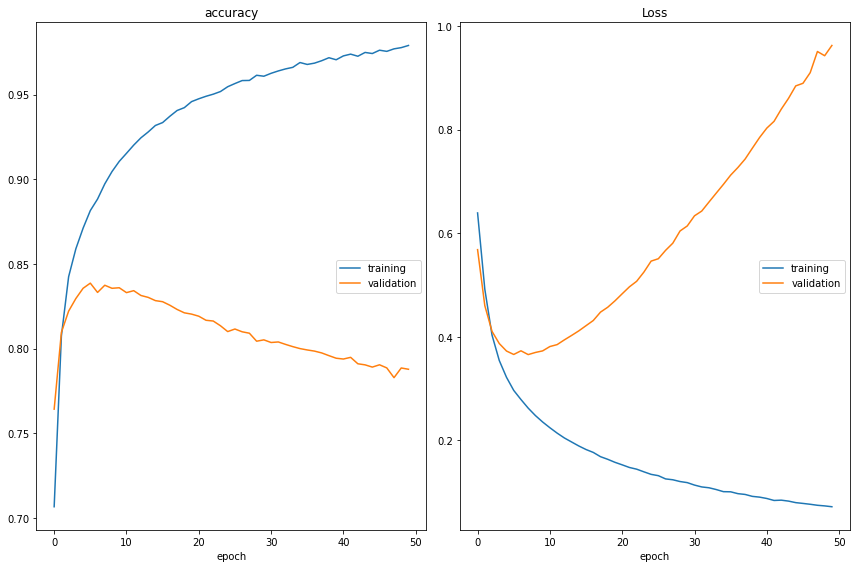

accuracy
	training         	 (min:    0.707, max:    0.979, cur:    0.979)
	validation       	 (min:    0.764, max:    0.839, cur:    0.788)
Loss
	training         	 (min:    0.072, max:    0.639, cur:    0.072)
	validation       	 (min:    0.365, max:    0.963, cur:    0.963)
782/782 [==============================] - 5s 7ms/step - loss: 0.0716 - accuracy: 0.9790 - val_loss: 0.9626 - val_accuracy: 0.7878


In [13]:
history = model.fit(training_sequence, training_labels_final, epochs=num_epochs, validation_data=(testing_sequence, testing_labels_final), callbacks=[PlotLossesKerasTF()])

In [14]:
loss, accuracy = model.evaluate(testing_sequence, testing_labels_final)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 2ms/step - loss: 0.9626 - accuracy: 0.7878
Loss:  0.9625738859176636
Accuracy:  0.7878400087356567


We have achieved an accurracy of ~79% on our Test set with a relatively simple model.

### Bidirectional LSTM Model

In [15]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


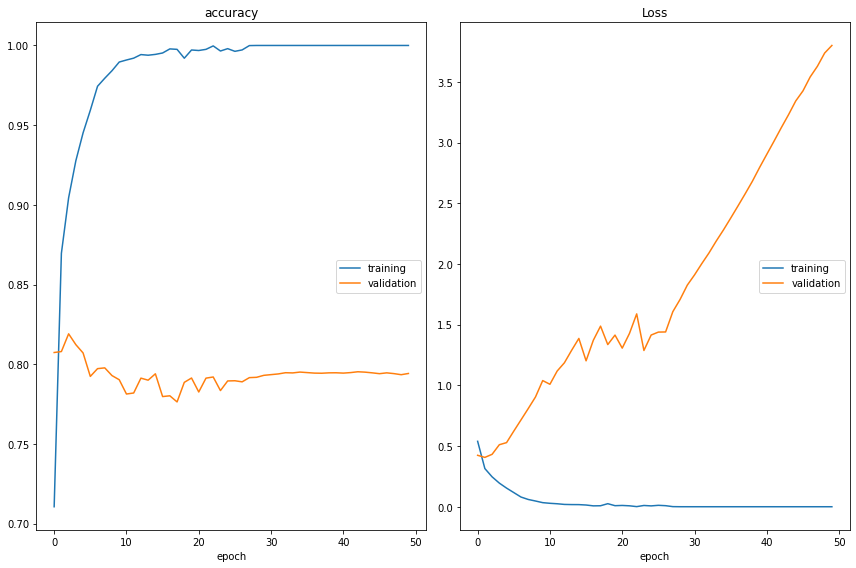

accuracy
	training         	 (min:    0.711, max:    1.000, cur:    1.000)
	validation       	 (min:    0.776, max:    0.819, cur:    0.794)
Loss
	training         	 (min:    0.000, max:    0.539, cur:    0.000)
	validation       	 (min:    0.406, max:    3.800, cur:    3.800)
782/782 [==============================] - 16s 20ms/step - loss: 9.2798e-09 - accuracy: 1.0000 - val_loss: 3.7996 - val_accuracy: 0.7942


In [16]:
history_lstm = model_lstm.fit(training_sequence, training_labels_final, epochs=num_epochs, validation_data=(testing_sequence, testing_labels_final), callbacks=[PlotLossesKerasTF()])

In [17]:
loss_lstm, accuracy_lstm = model_lstm.evaluate(testing_sequence, testing_labels_final)

print("Loss: ", loss_lstm)
print("Accuracy: ", accuracy_lstm)

782/782 [==============================] - 5s 6ms/step - loss: 3.7996 - accuracy: 0.7942
Loss:  3.7995831966400146
Accuracy:  0.7942000031471252


### GRU Model

In [18]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


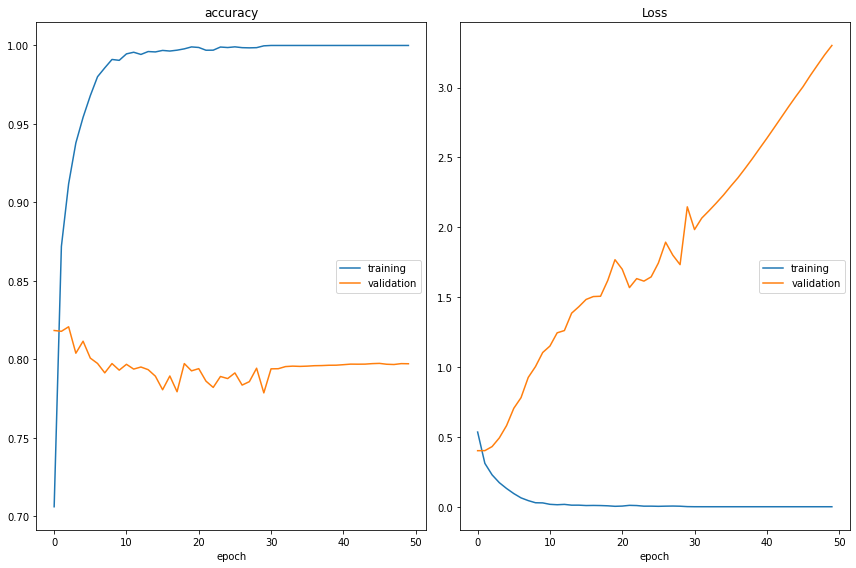

accuracy
	training         	 (min:    0.706, max:    1.000, cur:    1.000)
	validation       	 (min:    0.779, max:    0.821, cur:    0.797)
Loss
	training         	 (min:    0.000, max:    0.535, cur:    0.000)
	validation       	 (min:    0.401, max:    3.301, cur:    3.301)
782/782 [==============================] - 16s 20ms/step - loss: 2.3914e-08 - accuracy: 1.0000 - val_loss: 3.3014 - val_accuracy: 0.7972


In [19]:
history_gru = model_gru.fit(training_sequence, training_labels_final, epochs=num_epochs, validation_data=(testing_sequence, testing_labels_final), callbacks=[PlotLossesKerasTF()])

In [20]:
loss_gru, accuracy_gru = model_gru.evaluate(testing_sequence, testing_labels_final)

print("Loss: ", loss_gru)
print("Accuracy: ", accuracy_gru)

782/782 [==============================] - 5s 6ms/step - loss: 3.3014 - accuracy: 0.7972
Loss:  3.301435708999634
Accuracy:  0.7971600294113159


### Ensemble Model

In [21]:
model_en = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_en.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_en.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 120, 16)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 64)           5184      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

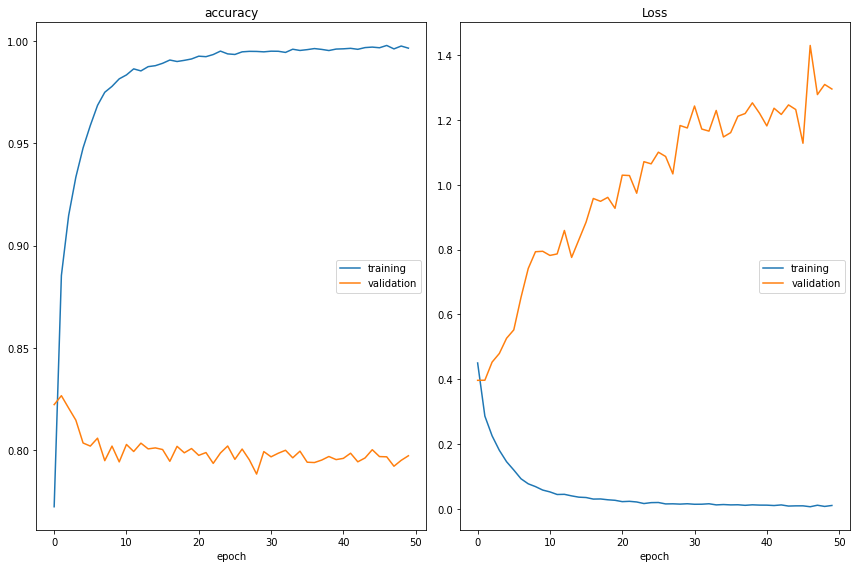

accuracy
	training         	 (min:    0.772, max:    0.998, cur:    0.997)
	validation       	 (min:    0.788, max:    0.827, cur:    0.797)
Loss
	training         	 (min:    0.006, max:    0.450, cur:    0.010)
	validation       	 (min:    0.397, max:    1.430, cur:    1.296)
782/782 [==============================] - 8s 11ms/step - loss: 0.0103 - accuracy: 0.9965 - val_loss: 1.2959 - val_accuracy: 0.7973


In [22]:
history_en = model_en.fit(training_sequence, training_labels_final, epochs=num_epochs, validation_data=(testing_sequence, testing_labels_final), callbacks=[PlotLossesKerasTF()])

In [23]:
loss_en, accuracy_en = model_en.evaluate(testing_sequence, testing_labels_final)

print("Loss: ", loss_en)
print("Accuracy: ", accuracy_en)

782/782 [==============================] - 2s 3ms/step - loss: 1.2959 - accuracy: 0.7973
Loss:  1.2959471940994263
Accuracy:  0.7972800135612488


## Observations:

* All of our models perform very well on Training dataset (~100% accuracy), but give ~80% accuracy on validaton set, thus exhibiting overfitting
* Training time of the Simple model is the fastest ~5s per epoch, Ensemble model at ~8s per epoch, while LSTM and GRU take the longest time to train ~16s per epoch
* Validation accuracy of Simple model keeps on decreasing with each epoch, while 
* Keeping in mind the training time, and accuracy (both Training and Validation), the Ensemble Model can be considered as the best

### Inference on new data

To get predictions for new examples, we can simply call `model.predict()`.

In [24]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

In [25]:
model.predict(transform_string(examples))

array([[0.85353875],
       [0.49272555],
       [0.18369019]], dtype=float32)

* **"The movie was phenomenal!"** - Result of 0.85 shows that the sentiment is very positive.
* **"The movie was okay."** - Result of 0.49 shows a neutral sentiment.
* **"The movie was terrible..."** - Result of 0.18 shows a negative sentiment.

## Visualize Word Embeddings using Tensorboard Projector

We will use the weights of Embedding layer and the Word Index to visualize the relationship and similarity betwwen words, using `Tensorboard Projector`.

Link: http://projector.tensorflow.org/

In [26]:
e = model_en.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [27]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

Upload the `vecs.tsv` and `meta.tsv` file on the Tensorboard page, and we can observe the following relationship between words:

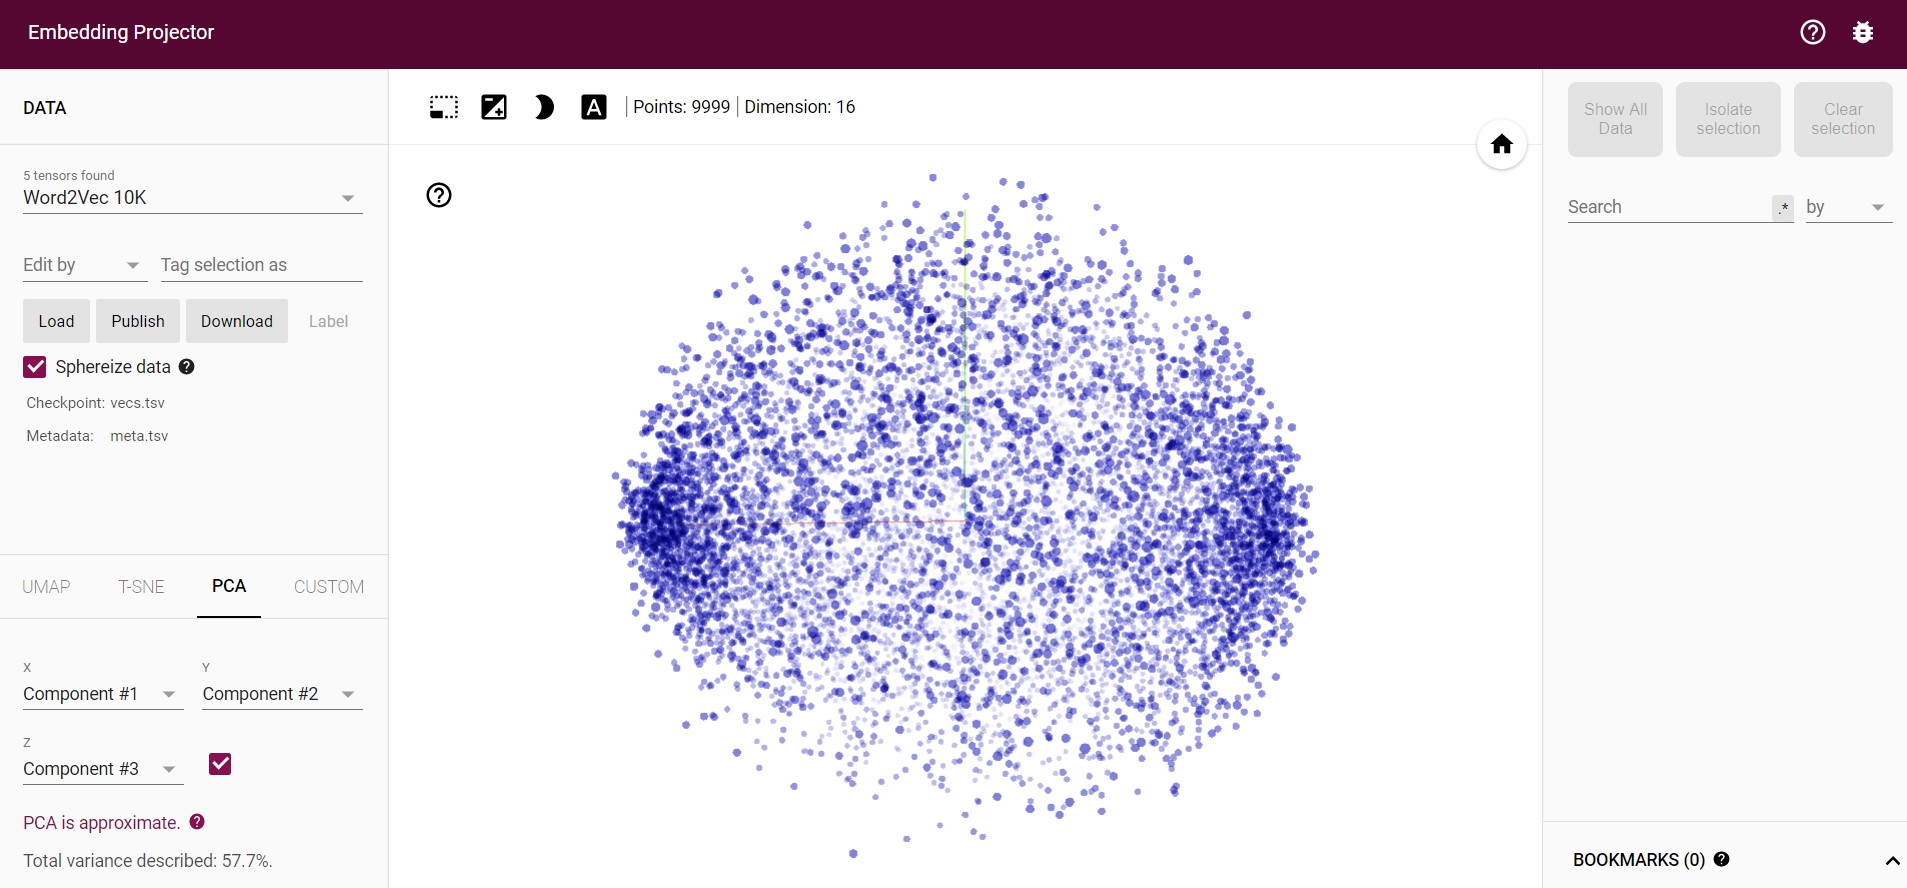

We can see dense clusters at the opposite ends of the sphere, indicating positive and negative word clusters

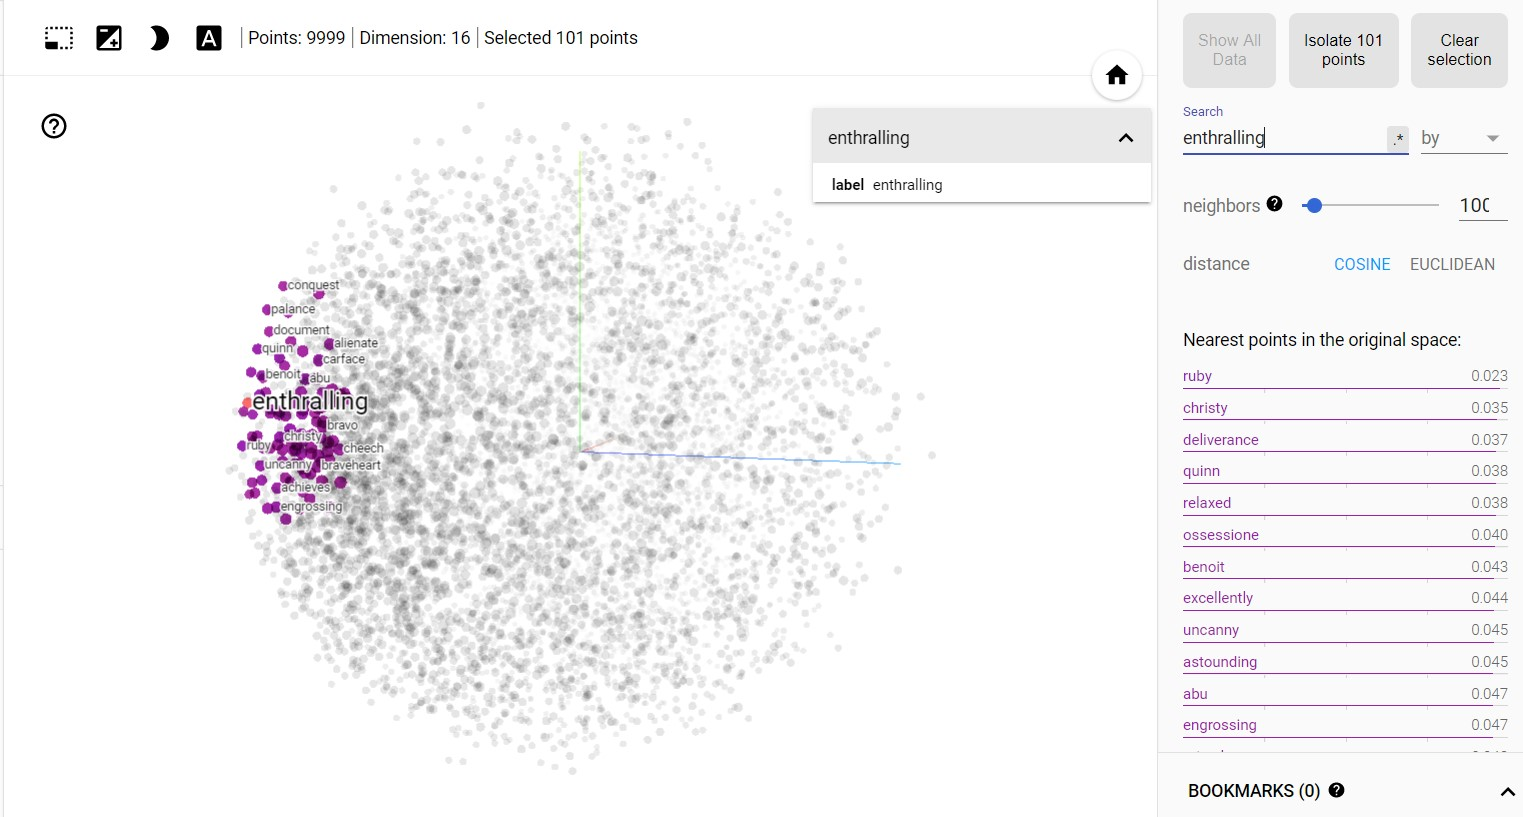

#### Positive word like "Enthralling" is nearby other positive words such as Excellently, Astounding, Engrossing

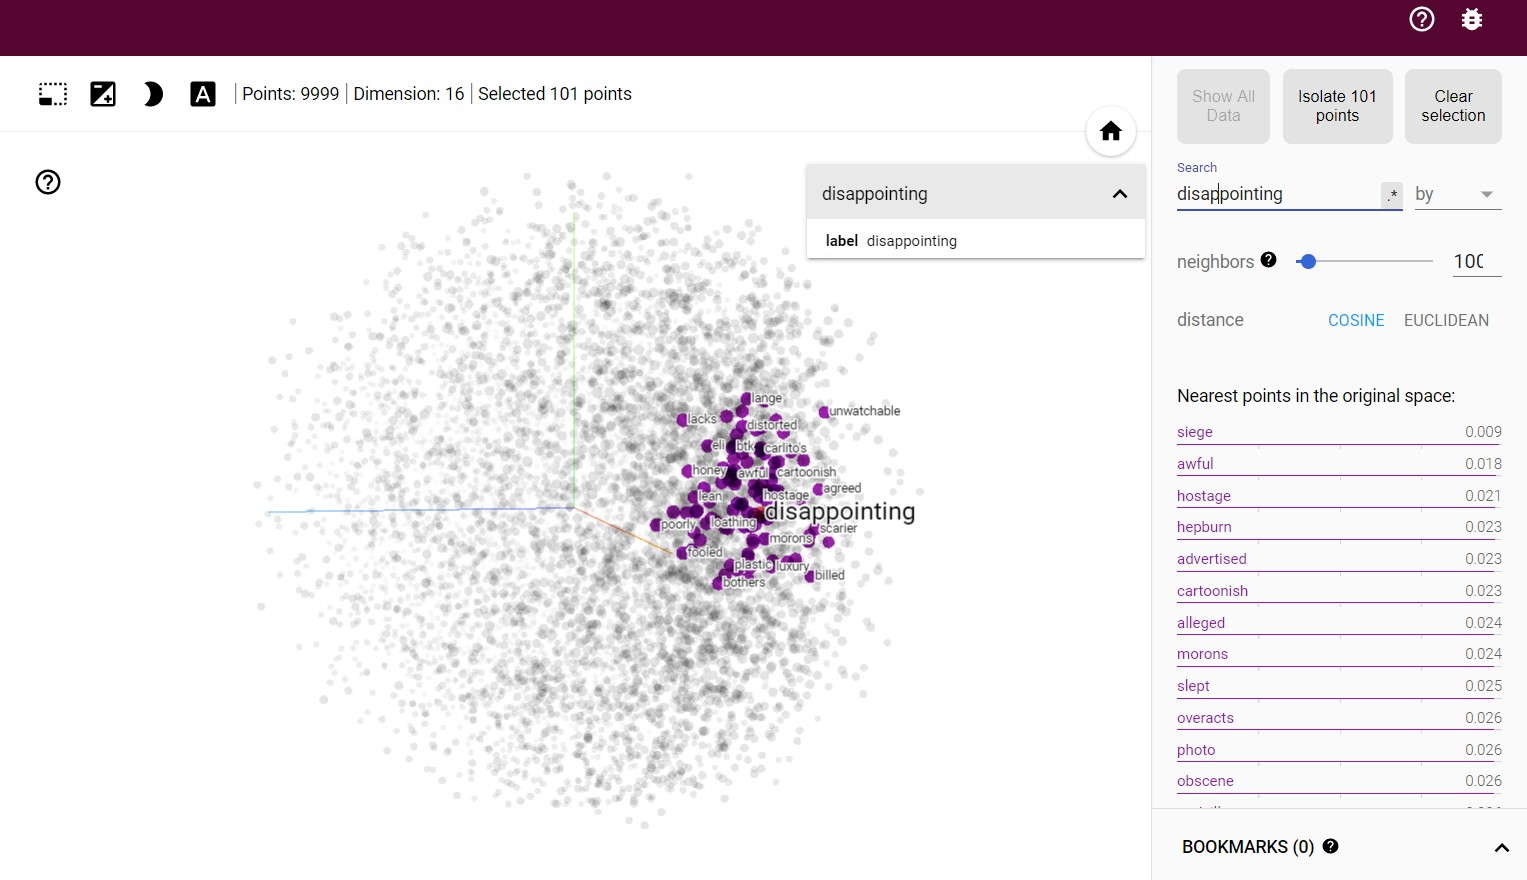

#### Negative word like "Disappointing" is near other negative words such as Awful, Cartoonish, Obscene etc.